# Исследование данных о продажах игр

Цели проекта:
1. Выявить закономерности, определяющие успешность игры
2. Проверить две гипотезы:
    * средние пользовательские рейтинги платформ Xbox One и PC одинаковые
    * средние пользовательские рейтинги жанров Action и Sports разные

<h1>План выполнения проекта<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предобработка-данных" data-toc-modified-id="Предобработка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Предобработка данных</a></span></li><li><span><a href="#Исследовательский-анализ-данных" data-toc-modified-id="Исследовательский-анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследовательский анализ данных</a></span></li><li><span><a href="#Портреты-геймеров" data-toc-modified-id="Портреты-геймеров-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Портреты геймеров</a></span></li><li><span><a href="#Проверка-гипотез" data-toc-modified-id="Проверка-гипотез-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка гипотез</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

## Предобработка данных

Подключим необходимые модули и выставим полезные умолчания.

In [1]:
import math as mt
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt

plt.style.use('dark_background'); # темный фон графиков
plt.rc('axes', grid=True, axisbelow=True); # линии сетки позади графикаa
pd.options.mode.chained_assignment = None # выключение SettingWithCopyWarning
pd.set_option('display.max_columns', None); # снятие ограничения на число выводимых столбцов

Загрузим датасет и взглянем на него.

In [2]:
try:
    df = pd.read_csv('/datasets/games.csv')
except:
    df = pd.read_csv(r'D:\datasets\games.csv')

In [3]:
df

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16711,LMA Manager 2007,X360,2006.0,Sports,0.00,0.01,0.00,0.00,NaN,NaN,NaN
16712,Haitaka no Psychedelica,PSV,2016.0,Adventure,0.00,0.00,0.01,0.00,NaN,NaN,NaN
16713,Spirits & Spells,GBA,2003.0,Platform,0.01,0.00,0.00,0.00,NaN,NaN,NaN


Приведем названия столбцов к нижнему регистру и переименуем для краткости столбец с годом выпуска игры.

In [4]:
df.columns = df.rename(columns={'Year_of_Release': 'year'}).columns.str.lower()

Посмотрим на типы данных.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          16713 non-null  object 
 1   platform      16715 non-null  object 
 2   year          16446 non-null  float64
 3   genre         16713 non-null  object 
 4   na_sales      16715 non-null  float64
 5   eu_sales      16715 non-null  float64
 6   jp_sales      16715 non-null  float64
 7   other_sales   16715 non-null  float64
 8   critic_score  8137 non-null   float64
 9   user_score    10014 non-null  object 
 10  rating        9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Типы не оптимальны. Проверим датасет на полные дубли.

In [6]:
df.duplicated().sum()

0

Дублей нет. Посмотрим на количество пропусков.

In [7]:
df.isna().sum()

name               2
platform           0
year             269
genre              2
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score    8578
user_score      6701
rating          6766
dtype: int64

В столбцах с названием и жанром игры всего по два пропуска. Скорее всего, это одни и те же строки. Проверим.

In [8]:
df[df['name'].isna()]

,name,platform,year,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Строки те же. Такие пропуски могли появиться из-за ошибок при сборе исходных данных. Удалять их не будем, т.к. платформа указана, продажи ненулевые, а по году выпуска они, скорее всего, все равно будут отсеяны позднее.

Посмотрим, какие есть платформы.

In [9]:
df['platform'].value_counts(dropna=False)

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
GB        98
NES       98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

Список внушительный, но не настолько, чтобы не привести столбец к категориальному типу.

In [10]:
df['platform'] = df['platform'].astype('category')

Посмотрим, насколько древние игры представлены в датасете.

In [11]:
df['year'].value_counts(dropna=False).sort_index()

1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      62
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
NaN        269
Name: year, dtype: int64

Данные аж с 1980 года. У 269 игр не указан год выпуска. Трудно представить, почему. Посмотрим, как распределены игры без года по датасету.

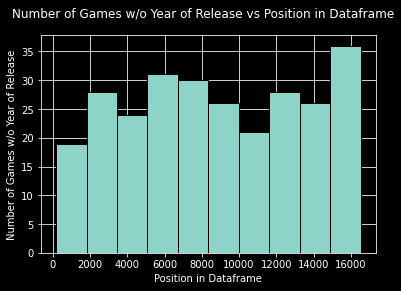

In [12]:
df[df['year'].isna()].reset_index()['index'].plot(kind='hist', edgecolor='k');
plt.suptitle('Number of Games w/o Year of Release vs Position in Dataframe');
plt.xlabel('Position in Dataframe');
plt.ylabel('Number of Games w/o Year of Release');

Очень напоминает равномерное распределение. Возможно, год специально (в образовательных целях) удалили у некоторых игр, выбраных случайно. Удалим игры без года выпуска, т.к. он будет необходим для дальнейшего анализа.

In [13]:
df = df.dropna(subset=['year'])

Приведем столбец с годом к минимальному беззнаковому целочисленному типу.

In [14]:
df['year'] = pd.to_numeric(df['year'], downcast='unsigned')

Посмотрим на перечень игровых жанров.

In [15]:
df['genre'].value_counts(dropna=False)

Action          3307
Sports          2306
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1226
Platform         878
Simulation       857
Fighting         837
Strategy         673
Puzzle           569
NaN                2
Name: genre, dtype: int64

Ничего необычного. Два пропуска в тех же строках, что и у названия, как выяснили выше. Приведем столбец к категориальному типу.

In [16]:
df['genre'] = df['genre'].astype('category')

В столбцах с продажами нет пропусков. Сами продажи указаны в миллионах копий с точностью до двух знаков после запятой. Для экономии памяти и повышения скорости обработки датасета выразим продажи в тысячах копий и приведем эти столбцы к минимальному беззнаковому целочисленному типу.

In [17]:
df.loc[:, 'na_sales':'other_sales'] = (
    (1000 * df.loc[:, 'na_sales':'other_sales']) # переводим в тысячи копий
    .round() # округляем до целого, чтобы убрать погрешность чисел с плавающей запятой
    .apply(pd.to_numeric, downcast='unsigned') # даункастим до целого без знака
)

Посмотрим на значения в столбце с оценками критиков.

In [18]:
df['critic_score'].value_counts(dropna=False)

NaN     8463
70.0     252
71.0     248
75.0     240
80.0     235
        ... 
20.0       3
29.0       3
21.0       1
17.0       1
13.0       1
Name: critic_score, Length: 82, dtype: int64

Целочисленные по сути значения, но очень много пропусков, которые, скорее всего, означают отсутствие оценки критиков в том источнике, откуда была взята эта информация. Пропуски удалять не будем, потому что тогда лишимся половины датасета, которая будет полезна для последующего анализа. Приведем столбец к более экономичному подтипу типа `float`.  

In [19]:
df['critic_score'] = pd.to_numeric(df['critic_score'], downcast='float')

Теперь посмотрим на оценки геймеров.

In [20]:
df['user_score'].value_counts(dropna=False)

NaN    6607
tbd    2376
7.8     322
8       285
8.2     276
       ... 
0.6       2
9.6       2
1.1       2
0         1
9.7       1
Name: user_score, Length: 97, dtype: int64

Примерно столько же пропусков, как и у оценок критиков, если считать «*tbd*» («*to be determined*»), по тем же возможным причинам. Заменим значение «*tbd*» на его в данном случае синоним `NaN` и приведем столбец к более экономичному подтипу типа `float`.

In [21]:
df['user_score'] = df['user_score'].replace('tbd', np.nan)

In [22]:
df['user_score'] = pd.to_numeric(df['user_score'], downcast='float')

Посмотрим на столбец с рейтингами.

In [23]:
df['rating'].value_counts(dropna=False)

NaN     6678
E       3921
T       2905
M       1536
E10+    1393
EC         8
K-A        3
AO         1
RP         1
Name: rating, dtype: int64

Много пропусков. Причиной может быть либо реально отсутствие рейтинга ESRB либо отсутствие части игр в источнике, из которого бралась информация о рейтинге.

Пропуски и `RP` (*Rating Pending*) для удобства переименуем в `-`. Устаревшие рейтинги `K-A` (*Kids to Adults*) и `EC` (*Early Childhood*) заменим их современным аналогом `E` (*Everyone*). Единственной игре с рейтингом `AO` (*Adults Only 18+*) поменяем его на соседний `M` (*Mature 17+*): одна игра картины не изменит, зато не будет лишней категории, а рейтинги при этом очень близкие.

Наконец, приведем столбец к категориальному типу, а категории отсортируем по старшинству.

In [24]:
df['rating'] = (df['rating']
                .fillna('-')
                .replace({'RP': '-', 
                          'K-A': 'E',
                          'EC': 'E',
                          'AO': 'M'})
                .astype('category')
                .cat.reorder_categories(['E', 'E10+', 'T', 'M', '-'], ordered=True)
)

In [25]:
df['rating'].value_counts(dropna=False).sort_index()

E       3932
E10+    1393
T       2905
M       1537
-       6679
Name: rating, dtype: int64

Перед столбцами с продажами по регионам добавим столбец с суммой продаж по всему миру.

In [26]:
df['total_sales'] = pd.to_numeric(df.loc[:, 'na_sales':'other_sales'].sum(axis=1), downcast='unsigned')

In [27]:
df = df[[
    'name', 
    'platform', 
    'year', 
    'genre',
    'total_sales',
    'na_sales', 
    'eu_sales',
    'jp_sales',
    'other_sales',
    'critic_score',
    'user_score',
    'rating'
]]

Насладимся превью, оптимизированными типами и уменьшенным размером обновленного датасета :)

In [28]:
df

,name,platform,year,genre,total_sales,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006,Sports,82540,41360,28960,3770,8450,76.0,8.0,E
1,Super Mario Bros.,NES,1985,Platform,40240,29080,3580,6810,770,NaN,NaN,-
2,Mario Kart Wii,Wii,2008,Racing,35520,15680,12760,3790,3290,82.0,8.3,E
3,Wii Sports Resort,Wii,2009,Sports,32770,15610,10930,3280,2950,80.0,8.0,E
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,31380,11270,8890,10220,1000,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,10,0,0,10,0,NaN,NaN,-
16711,LMA Manager 2007,X360,2006,Sports,10,0,10,0,0,NaN,NaN,-
16712,Haitaka no Psychedelica,PSV,2016,Adventure,10,0,0,10,0,NaN,NaN,-
16713,Spirits & Spells,GBA,2003,Platform,10,10,0,0,0,NaN,NaN,-


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   name          16444 non-null  object  
 1   platform      16446 non-null  category
 2   year          16446 non-null  uint16  
 3   genre         16444 non-null  category
 4   total_sales   16446 non-null  uint32  
 5   na_sales      16446 non-null  uint16  
 6   eu_sales      16446 non-null  uint16  
 7   jp_sales      16446 non-null  uint16  
 8   other_sales   16446 non-null  uint16  
 9   critic_score  7983 non-null   float32 
 10  user_score    7463 non-null   float32 
 11  rating        16446 non-null  category
dtypes: category(3), float32(2), object(1), uint16(5), uint32(1)
memory usage: 660.4+ KB


## Исследовательский анализ данных

Посмотрим на динамику выпуска игр по годам.

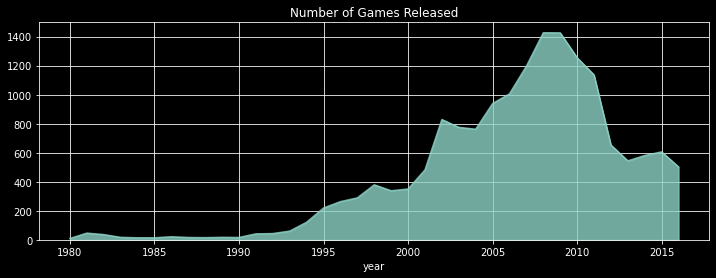

In [30]:
df.groupby('year')['name'].count().plot(kind='area', figsize=(12, 4), alpha=.8, title='Number of Games Released');

В 80-х ежегодное число новых игровых релизов почти не менялось. В первой половине 90-х оно начало быстро расти и достигло пика в 2008–2009. А с 2010-го каждый год новых игр на консолях и PC выходит все меньше и меньше. Возможно, перелом тренда связан с выходом первого iPhone в 2007 и последующим смещением приоритета разработки игр от консолей и PC к мобильным платформам.

Для прогнозирования на будущие периоды имеет смысл брать данные с 2009 года – после последней смены тренда.

Выделим 10 топовых игровых платформ по суммарным продажам за все время. 

In [31]:
top_platforms = (
    df.groupby('platform')['total_sales'].sum() # суммируем продажи по платформам
    .sort_values(ascending=False).head(10).index # оставляем первые 10 по объему продаж
)
list(top_platforms)

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']

Для топ-10 платформ построим распределение по годам числа выходивших на них игр.

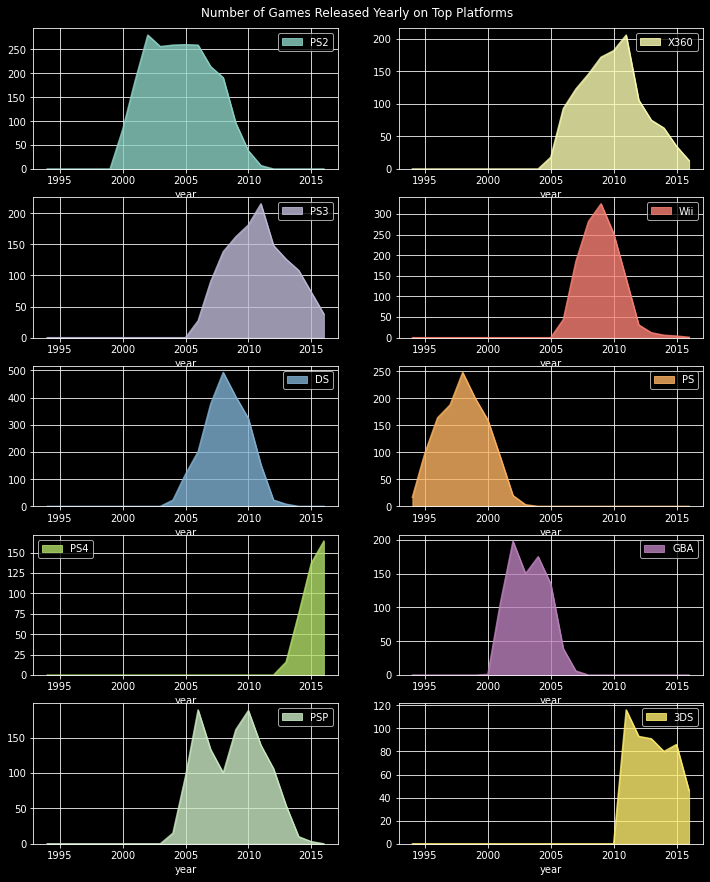

In [32]:
rows = mt.ceil(len(top_platforms) / 2) # число рядов по два графика в каждом
(
    df.pivot_table(values='name', index='year', columns='platform', aggfunc='count')[top_platforms]
    [lambda df: df.sum(axis=1) > 1] # фильтруем годы без (или почти без) продаж
    .plot(kind='area', subplots=True, sharex=False, alpha=.8, layout=(rows, 2), figsize=(12, 3*rows))
);
plt.suptitle('Number of Games Released Yearly on Top Platforms', y=.9);

Видно, что время жизни платформы, если определять его как период, когда для нее выпускаются игры, составляет порядка 10 лет. При этом активный период, когда выпускается много игр для платформы, примерно вдвое короче. 

Далее будем анализировать данные только за *актуальный период*, в качестве которого возьмем 2014–2016 годы – примерно половину характерного срока активной жизни платформ.

In [33]:
df = df.query("year >= 2014")

In [34]:
df

,name,platform,year,genre,total_sales,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,14630,6030,5860,360,2380,NaN,NaN,-
42,Grand Theft Auto V,PS4,2014,Action,12620,3960,6310,380,1970,97.0,8.3,M
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,11680,4350,3490,3100,740,NaN,NaN,-
77,FIFA 16,PS4,2015,Sports,8580,1120,6120,60,1280,82.0,4.3,E
87,Star Wars Battlefront (2015),PS4,2015,Shooter,7980,2990,3490,220,1280,NaN,NaN,-
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,10,0,0,10,0,NaN,NaN,-
16707,Aiyoku no Eustia,PSV,2014,Misc,10,0,0,10,0,NaN,NaN,-
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,10,0,0,10,0,NaN,NaN,-
16712,Haitaka no Psychedelica,PSV,2016,Adventure,10,0,0,10,0,NaN,NaN,-


Проверим, в каких столбцах остались пропуски.

In [35]:
df.isna().sum()

name              0
platform          0
year              0
genre             0
total_sales       0
na_sales          0
eu_sales          0
jp_sales          0
other_sales       0
critic_score    971
user_score      801
rating            0
dtype: int64

У стобцов категориального типа удалим лишние категории, данных по которым нет после фильтрации периода.

In [36]:
df = df.apply(lambda col: col.cat.remove_unused_categories() if col.dtype.name == 'category' else col)

Посмотрим, какие платформы лидируют по продажам.

In [37]:
platforms = (
    df.groupby('platform') # группируем по платформе
    .agg(games=('name', 'count'), total_sales=('total_sales', 'sum')) # считаем число игр и их продажи
    .sort_values(by='total_sales', ascending=False) # сортируем по убыванию продаж
    .apply(pd.to_numeric, downcast='unsigned') # даункастим до беззнакового целого
)
# добавляем средние продажи одной игрыи
platforms['sales_per_game'] = pd.to_numeric((platforms['total_sales'] / platforms['games']).round(), downcast='unsigned')
platforms

,games,total_sales,sales_per_game
platform,,,
PS4,376,288150,766
XOne,228,140360,616
3DS,212,86680,409
PS3,219,68180,311
X360,111,48220,434
WiiU,73,42980,589
PC,151,27050,179
PSV,295,22400,76
Wii,11,5070,461


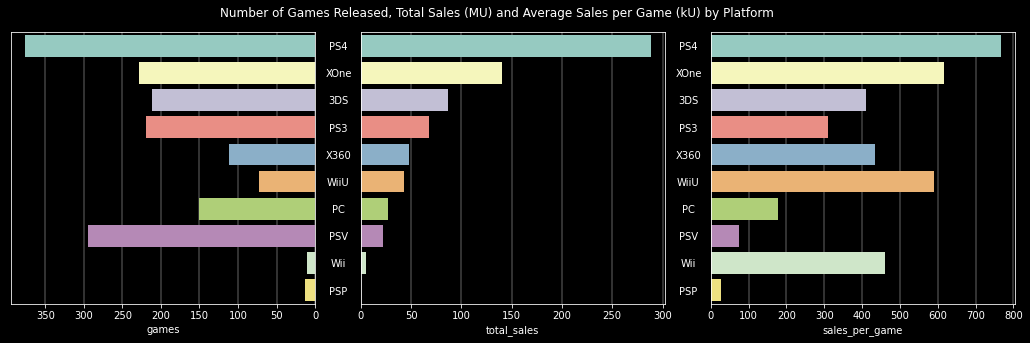

In [38]:
# строим столбчатые диаграммы для каждого столбца
(fig, ax) = plt.subplots(1, 3, figsize=(18, 5)) # задаем форму и размер области постоения
sns.barplot(x=platforms['games'], y=platforms.index, order=platforms.index, ax=ax[0]); # рисуем барплоты
sns.barplot(x=platforms['total_sales']/1000, y=platforms.index, order=platforms.index, ax=ax[1]);
sns.barplot(x=platforms['sales_per_game'], y=platforms.index, order=platforms.index, ax=ax[2]);
ax[0].invert_xaxis() # зеркалим первый график
ax[0].get_yaxis().set_visible(False) # убираем у него подписи и название вертикальной оси
ax[0].grid(visible=True, axis='x', linewidth=.4); # делаем вертикальные линии сетки бледными
for i in [1, 2]: # для двух оставшихся графиков:
    ax[i].set_ylabel(None) # убираем название вертикальной оси
    ax[i].tick_params(left=False) # убираем засечки на вертикальной оси
    ax[i].set_yticklabels(platforms.index, ha='center', position=(-.05, 0)) # выравниваем по центру подписи вертикальной оси
    ax[i].grid(visible=True, axis='x', linewidth=.4); # делаем вертикальные линии сетки бледными
fig.subplots_adjust(wspace=0.15) # подбираем оптимальное расстояние между графиками
fig.suptitle('Number of Games Released, Total Sales (MU) and Average Sales per Game (kU) by Platform', y=.95);

По суммарным продажам за последние 3 года и средним продажам на одну игру лидируют PS4 и XOne.

Посмотрим на *динамику* выпуска игр на платформах.

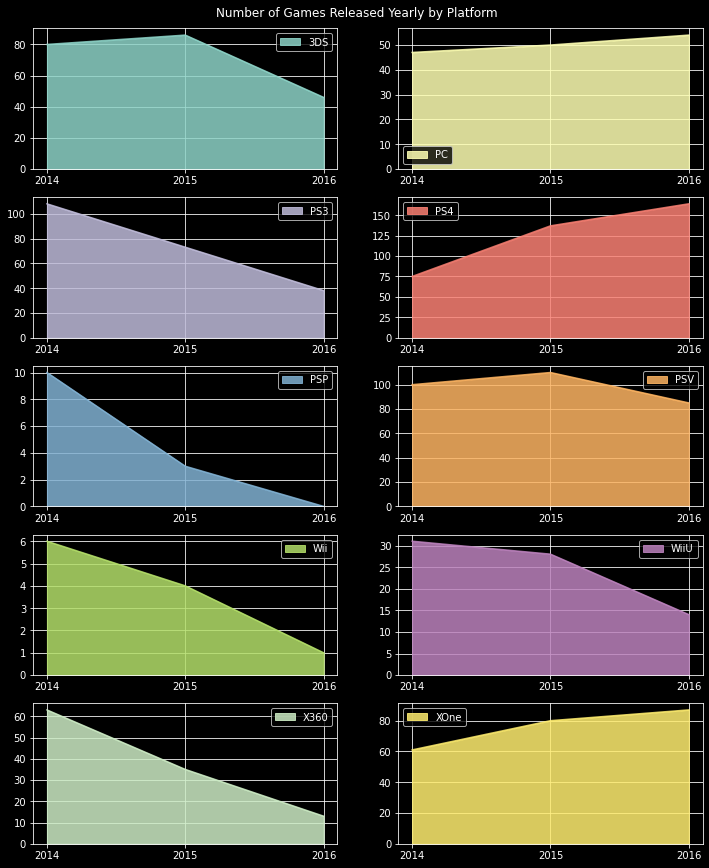

In [39]:
pivot = df.pivot_table(values='name', index='year', columns='platform', aggfunc='count') # считаем число игр 
rows = mt.ceil(len(pivot.columns) / 2); # число рядов графиков по два в каждом
colors = plt.rcParams['axes.prop_cycle']() # итератор цветов
(fig, ax) = plt.subplots(rows, 2, figsize=(12, 3*rows)) # устанавливаем форму и размер области построения
fig.suptitle('Number of Games Released Yearly by Platform', y=.9) 

for i, platform in enumerate(pivot.columns): # перебираем столцбцы-платформы
    pivot[platform].plot(ax=ax[i//2, i%2], kind='area', alpha=.85, color=next(colors)['color']) # рисуем график
    ax[i//2, i%2].set_xlabel(None); # убираем название горизонтальной оси
    ax[i//2, i%2].set_xticks([2014, 2015, 2016]) # явно задаем подписи горизонтальной оси
    ax[i//2, i%2].legend() # добавляем легенду

Платформы PSP и Wii в 2016 году уже мертвы: игр для них практически или вообще не выпускается. Стремительно падают по числу новых игр платформы 3DS, PS3, PSV, WiiU и X360. Немного больше с каждым годом становится игр на PC.

И лишь две платформы активно растут: PS4 и XOne. Учитывая средние продажи игр, эти две платформы представляются сейчас наиболее потенциально прибыльными.

Построим график «ящик с усами» по глобальным продажам игр в разрезе платформ.

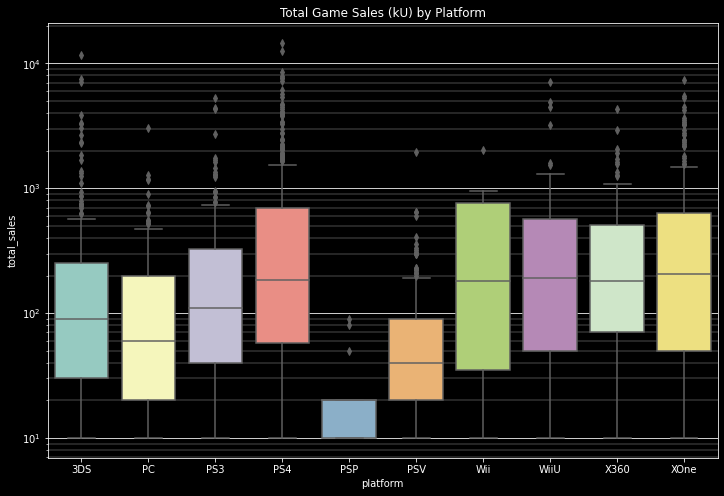

In [40]:
plt.figure(figsize=(12, 8));
plt.yscale('log'); # используем логарифмическую шкалу, чтобы охватить весь диапазон продаж и не потерять в детализации
ax = sns.boxplot(x=df['platform'], y=df['total_sales']);
ax.grid(b=True, which='minor', linewidth=.3);
ax.set_title('Total Game Sales (kU) by Platform');

По медианным продажам аутсайдерами являются платформы PSP и PSV. В лидерах XOne и WiiU, за которыми с минимальным отрывом следуют PS4, Wii и X360.

Посмотрим, как продажи игр коррелируют с оценками геймеров и критиков.

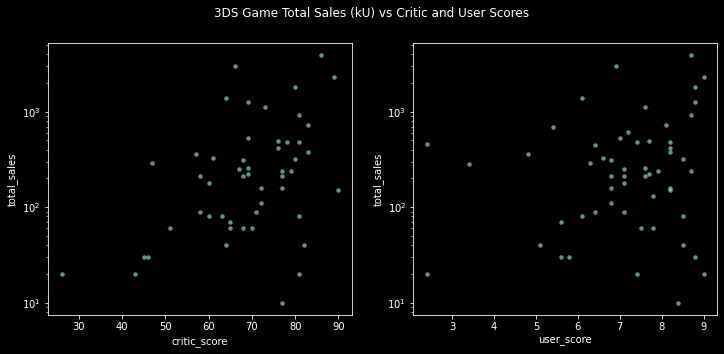

Correlation with critic_score: 0.44
Correlation with user_score: 0.16



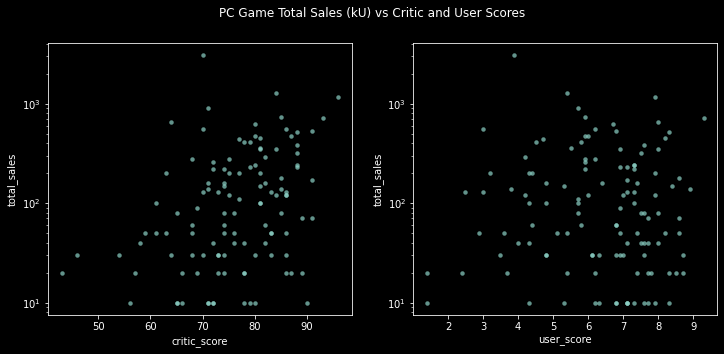

Correlation with critic_score: 0.35
Correlation with user_score: -0.02



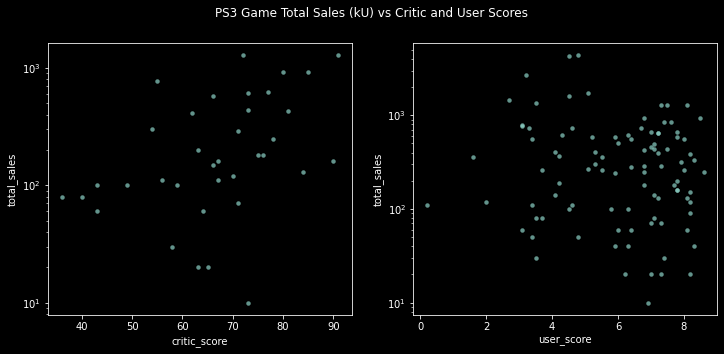

Correlation with critic_score: 0.41
Correlation with user_score: -0.10



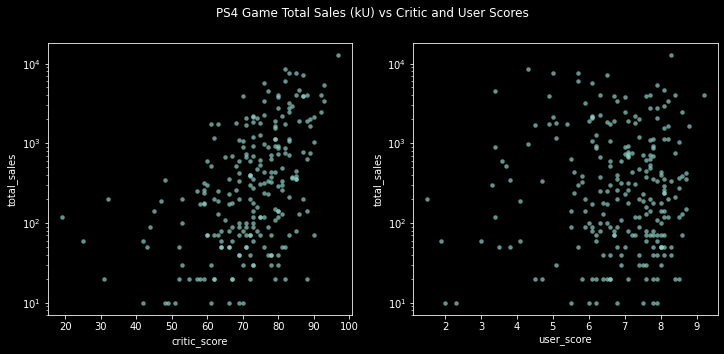

Correlation with critic_score: 0.49
Correlation with user_score: 0.03



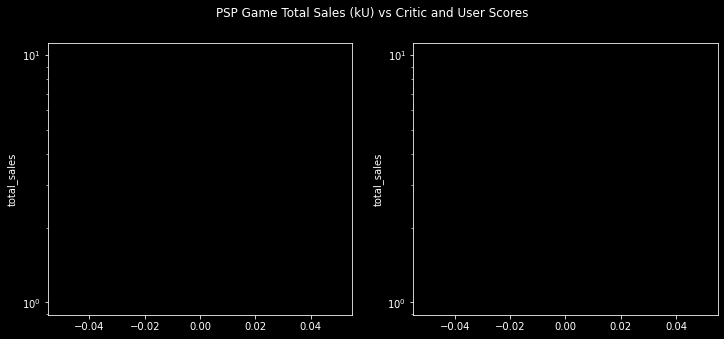

Correlation with critic_score: nan
Correlation with user_score: nan



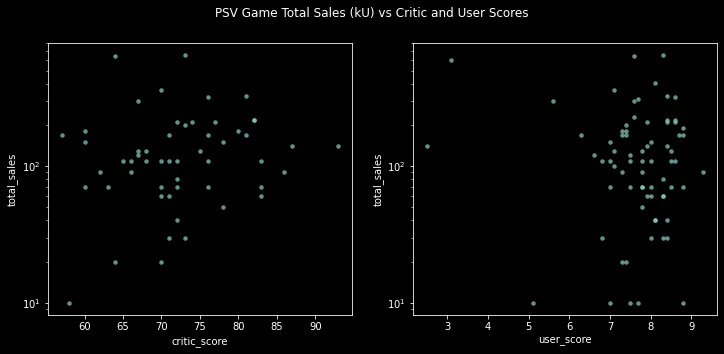

Correlation with critic_score: 0.18
Correlation with user_score: -0.06



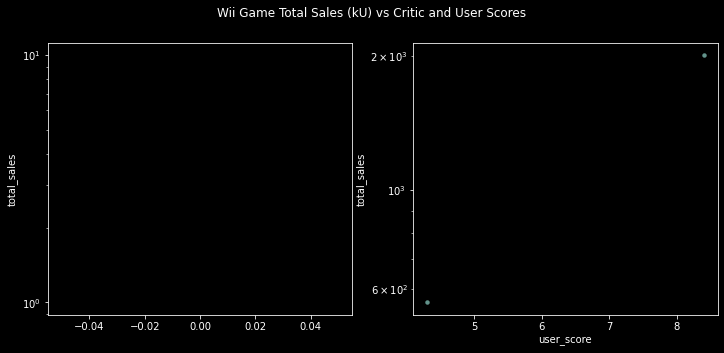

Correlation with critic_score: nan
Correlation with user_score: 1.00



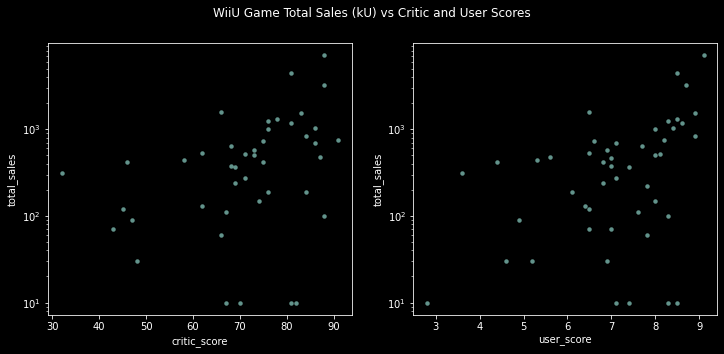

Correlation with critic_score: 0.33
Correlation with user_score: 0.38



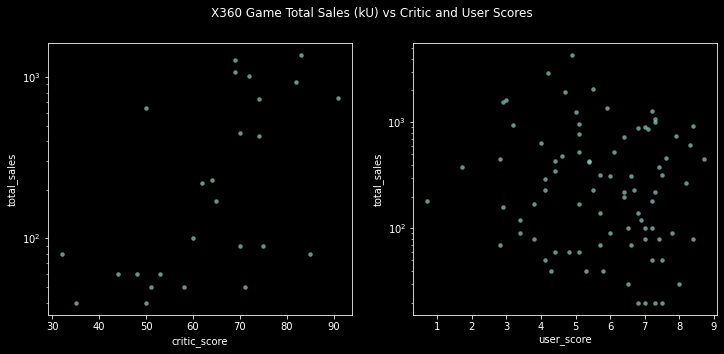

Correlation with critic_score: 0.59
Correlation with user_score: -0.14



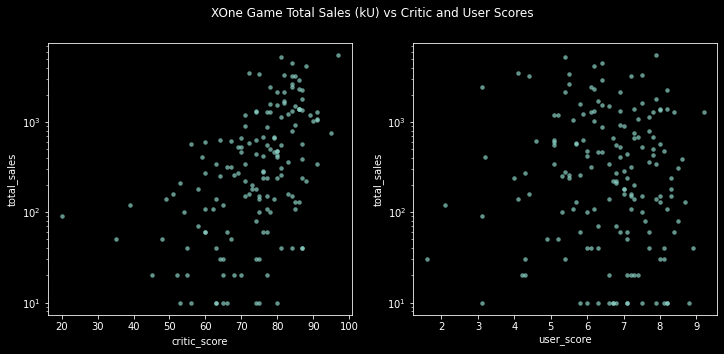

Correlation with critic_score: 0.51
Correlation with user_score: -0.04



In [41]:
platforms = sorted(list(df['platform'].unique())) # сортированный список платформ
cols = ['critic_score', 'user_score'] # список столбцов с оценками

for pf in platforms: # перебираем платформы
    df_pf = df[df['platform'] == pf] # срез датасета с играми текущей платформы
    (fig, ax) = plt.subplots(1, len(cols), figsize=(6*len(cols), 5)) # устанавливаем форму и размер области построения
    fig.suptitle(pf + ' Game Total Sales (kU) vs Critic and User Scores') # показываем название пары графиков – текущую платформу
    for (i, col) in enumerate(cols): # для каждой платформы выводим по скеттерплоту на столбец с оценками
        ax[i].set(yscale='log'); # логарифмический масштаб для продаж, как более естественный
        ax[i].grid(False); # выключаем сетку
        sns.scatterplot(data=df_pf, x=col, y='total_sales', linewidth=0, alpha=.7, s=20, ax=ax[i]); # рисуем график
    plt.show() # отображаем пару графиков
    for (i, col) in enumerate(cols): # для каждой платформы выводим по скеттерплоту на столбец с оценками
        # корреляцию считаем также с логарифмом продаж
        print(f"Correlation with {col}: {df_pf['total_sales'].apply(mt.log10).corr(df_pf[col]):.2f}") 
    print() # пустая строка для отделения от предыдущей пары графиков   

У большинства платформ корреляция логарифма продаж с оценками критиков значительно выше корреляции с оценками геймеров, но не превышает 0,6, т.е. является средней. Поэтому если и можно использовать оценки для прогнозирования продаж, то только оценки критиков.

Посмотрим, как по продажам распределились игровые жанры.

In [42]:
genres = (
    df.groupby('genre')
    .agg(games=('name', 'count'), total_sales=('total_sales', 'sum'))
    .sort_values(by='total_sales', ascending=False)
    .apply(pd.to_numeric, downcast='unsigned')
)
# добавляем средние продажи одной игрыи
genres['sales_per_game'] = pd.to_numeric((genres['total_sales'] / genres['games']).round(), downcast='unsigned')
genres

,games,total_sales,sales_per_game
genre,,,
Action,619,199360,322
Shooter,128,170940,1335
Sports,161,109480,680
Role-Playing,221,101440,459
Misc,113,37550,332
Fighting,60,28220,470
Racing,69,27520,399
Platform,38,18090,476
Adventure,185,17550,95


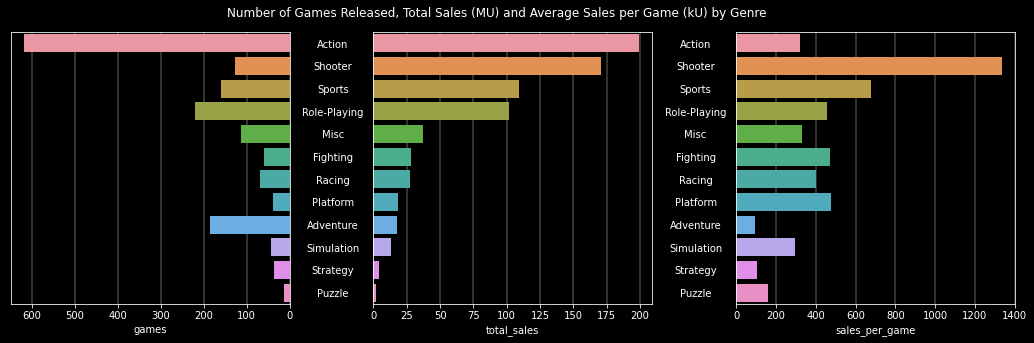

In [43]:
# строим столбчатые диаграммы для каждого столбца
(fig, ax) = plt.subplots(1, 3, figsize=(18, 5))
sns.barplot(x=genres['games'], y=genres.index, order=genres.index, ax=ax[0]);
sns.barplot(x=genres['total_sales']/1000, y=genres.index, order=genres.index, ax=ax[1]);
sns.barplot(x=genres['sales_per_game'], y=genres.index, order=genres.index, ax=ax[2]);
ax[0].invert_xaxis()
ax[0].get_yaxis().set_visible(False)
ax[0].grid(visible=True, axis='x', linewidth=.4);
for i in [1, 2]:
    ax[i].set_ylabel(None)
    ax[i].tick_params(left = False)
    ax[i].set_yticklabels(genres.index, ha='center', position=(-.12, 0))
    ax[i].grid(visible=True, axis='x', linewidth=.4);
fig.subplots_adjust(wspace=0.3);
fig.suptitle('Number of Games Released, Total Sales (MU) and Average Sales per Game (kU) by Genre', y=.95);

По суммарным продажам за последние 3 года лидируют жанры Action и Shooter. При этом жанр Shooter – абсолютный лидер по средним продажам на одну игру, а Action – по числу выпущенных игр.

Посмотрим на *динамику* выпуска игр разных жанров.

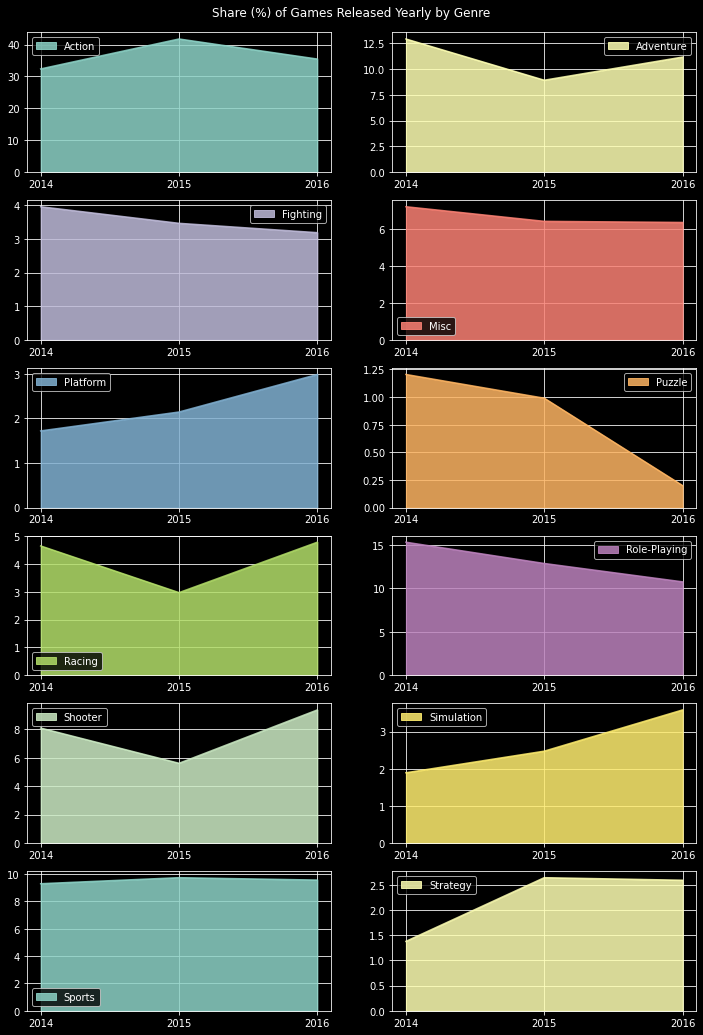

In [44]:
pivot = (
    df.pivot_table(values='name', index='year', columns='genre', aggfunc='count') # считаем число игр 
    .apply(lambda row: 100*row/row.sum(), axis=1) # в долях от общего числа игр, вышедших в году
)
rows = mt.ceil(len(pivot.columns) / 2); # число рядов графиков по два в каждом
colors = plt.rcParams['axes.prop_cycle']() # итератор цветов
(fig, ax) = plt.subplots(rows, 2, figsize=(12, 3*rows)) # устанавливаем форму и размер области построения
fig.suptitle('Share (%) of Games Released Yearly by Genre', y=.9) 

for i, genre in enumerate(pivot.columns): # перебираем столцбцы-жанры
    pivot[genre].plot(ax=ax[i//2, i%2], kind='area', alpha=.85, color=next(colors)['color']) # рисуем график
    ax[i//2, i%2].set_xlabel(None); # убираем название горизонтальной оси
    ax[i//2, i%2].set_xticks([2014, 2015, 2016]) # явно задаем подписи горизонтальной оси
    ax[i//2, i%2].legend() # добавляем легенду

Растут доли новых игр жанров Platform и Simulation. Падают доли у жанров Fighting, Misc и Role-Playing. Жанр Puzzle практически умер. Динамика остальных жанров переменная.

Построим график «ящик с усами» по глобальным продажам игр в разрезе жанров.

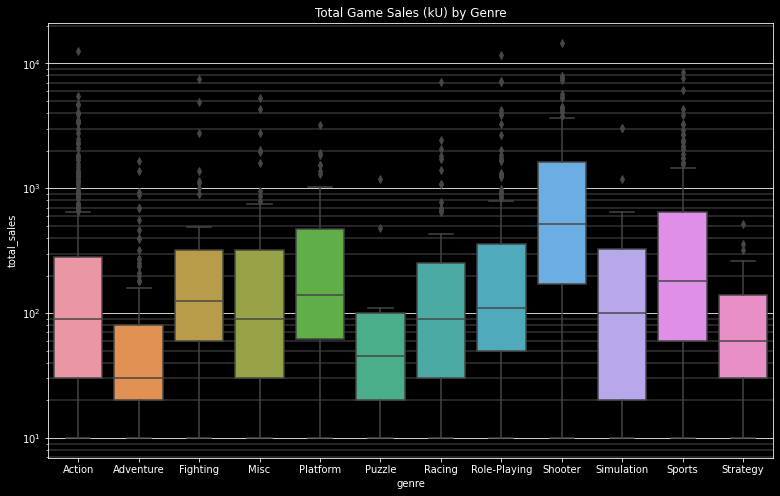

In [45]:
plt.figure(figsize=(13, 8));
plt.yscale('log'); # продажи, как всегда, в логарифмическом масштабе
ax = sns.boxplot(x=df['genre'], y=df['total_sales']);
ax.grid(b=True, which='minor', linewidth=.3);
ax.set_title('Total Game Sales (kU) by Genre');

По медианным продажам аутсайдерами являются жанры Adventure, Puzzle и Strategy. В явных лидерах только жанр Shooter, за которым с большим отрывом следуют Sports, Platform и Fighting. Жанр Simulation отличается бóльшим, чем у других, разбросом половины значений.

## Портреты геймеров

Для составления портретов геймеров напишем функцию, которая выводит топ `n` значений столбца `index` датафрейма по сумме в столбце `by` и считает доли от суммы по всему столбцу `by`.

In [46]:
def top_n(index, by, n=5):
    try:
        res = (
        df.groupby(index)[[by]].sum().sort_values(by=by, ascending=False)
        .apply(pd.to_numeric, downcast='unsigned')
        )
    except:
        print("Error: please provide valid 'index' and 'by' column names of the dataset")
        return
    res['share'] = pd.to_numeric((res[by] / res[by].sum() * 100).round(), downcast='unsigned')
    try:
        return res.head(n)
    except:
        print("Error: please specify number of rows 'n' to diplay, or omit it to display 5 rows")
        return

Выведем с помощью этой функции топ 5 платформ по объему продаж для каждого региона: Северная Америка, Европа и Япония.

In [47]:
top_n('platform', 'na_sales')

,na_sales,share
platform,,
PS4,98610,35
XOne,81270,29
X360,28300,10
3DS,22640,8
PS3,22050,8


In [48]:
top_n('platform', 'eu_sales')

,eu_sales,share
platform,,
PS4,130040,48
XOne,46250,17
PS3,25540,9
PC,17970,7
3DS,16120,6


In [49]:
top_n('platform', 'jp_sales')

,jp_sales,share
platform,,
3DS,44240,48
PS4,15020,16
PSV,14540,16
PS3,11220,12
WiiU,7310,8


Первые два места в Северной Америке и Европе занимают платформы PS4 и XOne. Составы пятерок в этих регионах отличаются всего одной позицией: в Северной Америке на третьем месте американская X360, а в Европе на четвертом месте PC. При этом лидер — японская PS4 — занимает половину рынка в Европе, но лишь треть рынка в Северной Америке.

Пятерка платформ в Японии кардинально отличается от двух других: в ней представлены только японские консоли, две из которых портативные, в том числе лидер — 3DS, занимающая половину рынка. PS4 на втором месте с долей всего 16%. Похоже, японцы ценят отечественного производителя и портативность.

Теперь повторим то же упражнение для игровых жанров: выведем для каждого региона топ 5 жанров по объему продаж.

In [50]:
top_n('genre', 'na_sales')

,na_sales,share
genre,,
Shooter,79020,28
Action,72530,26
Sports,46130,16
Role-Playing,33470,12
Misc,15050,5


In [51]:
top_n('genre', 'eu_sales')

,eu_sales,share
genre,,
Action,74680,28
Shooter,65520,24
Sports,45730,17
Role-Playing,28170,10
Racing,14130,5


In [52]:
top_n('genre', 'jp_sales')

,jp_sales,share
genre,,
Role-Playing,31160,33
Action,29580,32
Fighting,6370,7
Misc,5610,6
Shooter,4870,5


Пятерки жанров-лидеров в Северной Америке и Европе отличаются лишь пятым местом и порядком первых двух: в Северной Америке на первом месте Shooter, на пятом — Misc, а в Европе Action на первом и Racing на пятом. Процентовки топ-5 в этих регионах практически идентичные, доли двух лидеров отличаются незначительно.

Япония снова кардинально отличается: на первом и втором местах с минимальным отрывом здесь жанры Role-Playing, который был четвертым в двух других регионах, и Action, а жанр Shooter на пятом месте. При этом два лидера занимают по трети рынка, сильно отрываясь от остальных: доля третьего места — жанра Fighting — всего 7%. 

Посмотрим, влияет ли рейтинг ESRB на продажи в регионах. Для этого для каждого региона построим «ящик с усами» по продажам игр в разрезе рейтингов.

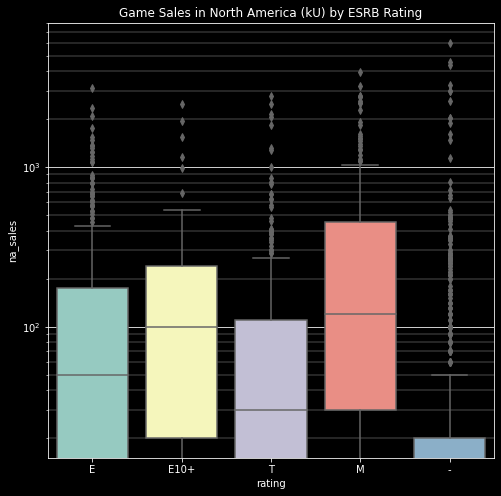

In [53]:
plt.figure(figsize=(8, 8));
plt.yscale('log');
ax = sns.boxplot(x=df['rating'], y=df['na_sales']);
ax.grid(b=True, which='minor', linewidth=.3);
ax.set_title('Game Sales in North America (kU) by ESRB Rating');

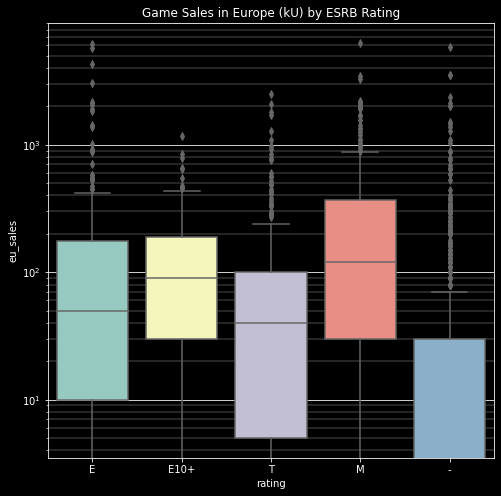

In [54]:
plt.figure(figsize=(8, 8));
plt.yscale('log');
ax = sns.boxplot(x=df['rating'], y=df['eu_sales']);
ax.grid(b=True, which='minor', linewidth=.3);
ax.set_title('Game Sales in Europe (kU) by ESRB Rating');

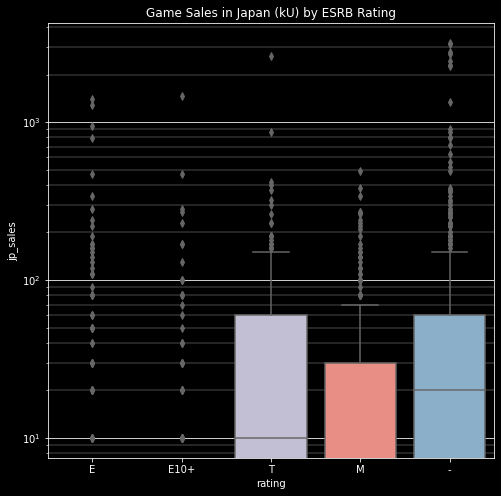

In [55]:
plt.figure(figsize=(8, 8));
plt.yscale('log');
ax = sns.boxplot(x=df['rating'], y=df['jp_sales']);
ax.grid(b=True, which='minor', linewidth=.3);
ax.set_title('Game Sales in Japan (kU) by ESRB Rating');

В Северной Америке и Европе выделяются рейтинги `M` (*Mature 17+*) и `E10+` (*Everyone 10+*) – медианные продажи игр с этими рейтингами заметно выше других. Также в обоих регионах игры без рейтинга сильно проигрывают в продажах играм с рейтингом: больше половины игр без рейтинга имеют продажи ниже 5000 копий (ноль с учетом точности и округления исходных данных).

Япония снова выделяется: продажи ниже 5000 копий здесь имеют больше 3/4 игр с рейтингами `E` (*Everyone*) и `E10+` (*Everyone 10+*), больше половины игр с рейтингом `M` (*Mature 17+*) и более четверти игр с рейтингом `T` (*Teen*) и игр без рейтинга. Т.е. в отличие от Северной Америки и Европы отсутствие рейтинга ESRB в Японии скорее означает бóльшие продажи.

## Проверка гипотез

Проверим первую гипотезу:
>средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Для этого сначала сохраним в отдельную переменную пользовательские рейтинги игр на платформах Xbox One и PC, после чего посмотрим на статистические показатели и распределение игр по рейтингам на каждой платформе.

In [56]:
plf = df.set_index('platform').loc[['PC', 'XOne'], 'user_score'].dropna()
plf.groupby('platform').describe().T[:3]

platform,PC,XOne
count,122.000000,165.000000
mean,6.298361,6.594544
std,1.703277,1.375139


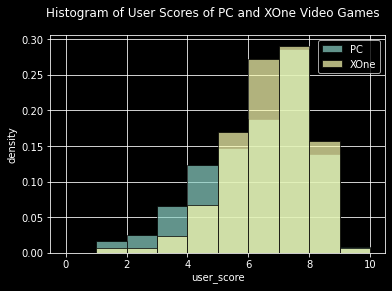

In [57]:
plf.groupby('platform').hist(density=True, alpha=.7, edgecolor='k', range=(0, 10));
plt.legend(['PC', 'XOne']);
plt.xlabel('user_score');
plt.ylabel('density');
plt.suptitle('Histogram of User Scores of PC and XOne Video Games');

Средний пользовательский рейтинг игр на Xbox One выше среднего рейтинга игр на PC. Стандартное отклонение среднего пользовательского рейтинга, напротив, выше у игр на PC. Выборки игр на двух платформах заметно отличаются по размеру.

Тестируемая нулевая гипотеза будет звучать так: 
>средние пользовательские рейтинги платформ Xbox One и PC *одинаковые*.

Сформулируем *двустороннюю* альтернативную гипотезу:
>средние пользовательские рейтинги платформ Xbox One и PC *различаются*.

Уровень значимости выберем стандартным: 5%. 

Выборки для каждой платформы качественно отличаются и не зависят друг от друга, поэтому для тестирования используем t-тест для двух независимых выборок `scipy.stats.ttest_ind()`.

Выборки также отличаются размером и стандартным отклонением, поэтому параметру `equal_var` присваиваем значение `False`.

In [58]:
st.ttest_ind(plf['PC'], plf['XOne'], equal_var=False)

Ttest_indResult(statistic=-1.5777542301416114, pvalue=0.1160154559677266)

Полученное p-value 0,12 превышает выбранный уровень значимости 0,05. Это значит, что мы не можем отвергнуть нулевую гипотезу в пользу альтернативной, т.е. средние пользовательские рейтинги платформ Xbox One и PC *одинаковые* при уровне значимости 5% или ниже. Рассчитаем средний пользовательский рейтинг игр на обеих платформах.

In [59]:
plf.mean()

6.4686418

Мы также не можем отвергнуть нулевую гипотезу в пользу *односторонней* альтернативной гипотезы: 
>средний пользовательский рейтинг платформы Xbox One *больше* среднего рейтинга платформы PC,

потому что для нее p-value будет вдвое ниже полученного – 0,06, но все равно выше выбранного уровня значимости 0,05.

<br>

Проверим вторую гипотезу:
>средние пользовательские рейтинги жанров Action и Sports разные.

Для этого снова сначала сохраним в отдельную переменную пользовательские рейтинги игр жанров Action и Sports, после чего посмотрим на статистические показатели и распределение игр каждого жанра по рейтингам.

In [60]:
gnr = df.set_index('genre').loc[['Action', 'Sports'], 'user_score'].dropna()
gnr.groupby('genre').describe().T[:3]

genre,Action,Sports
count,297.000000,127.000000
mean,6.760606,5.225197
std,1.377852,1.856604


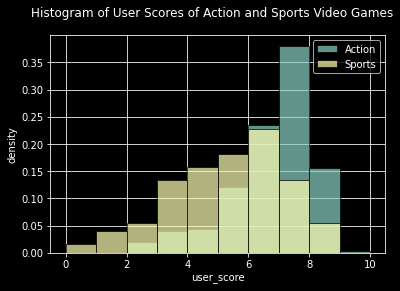

In [61]:
gnr.groupby('genre').hist(density=True, alpha=.7, edgecolor='k', range=(0, 10));
plt.legend(['Action', 'Sports']);
plt.xlabel('user_score');
plt.ylabel('density');
plt.suptitle('Histogram of User Scores of Action and Sports Video Games');

Средний пользовательский рейтинг и количество игр жанра Action сильно выше аналогичных показателей для жанра Sports, а вот стандартное отклонение, наоборот, ниже.

Сформулируем тестируемую нулевую гипотезу: 
>средние пользовательские рейтинги жанров Action и Sports *одинаковые*.

Альтернативная *двусторонняя* гипотеза будет звучать так:
>средние пользовательские рейтинги жанров Action и Sports *разные*.

Уровень значимости снова выберем 5%. 

Выборки для каждого жанра качественно отличаются и не зависят друг от друга, поэтому для тестирования опять используем t-тест для двух независимых выборок `scipy.stats.ttest_ind()`.

Выборки также отличаются размером и стандартным отклонением, поэтому параметру `equal_var` снова присваиваем значение `False`.

In [62]:
st.ttest_ind(gnr['Action'], gnr['Sports'], equal_var=False)

Ttest_indResult(statistic=8.384613481526166, pvalue=1.1825639880196408e-14)

Мы получили очень низкое p-value. Это значит, что нулевую гипотезу можно смело отвергнуть в пользу альтернативной и с уверенностью сказать, что средние пользовательские рейтинги жанров Action и Sports *разные* при практически любом уровне значимости.

Более того, средний пользовательский рейтинг жанра Action *больше* среднего пользовательского рейтинга жанра Sports при практически любом уровне значимости. Это *односторонняя* альтернативная гипотеза, которую также нужно принять, отвергнув нулевую гипотезу, потому что для нее p-value будет вдвое ниже полученного.

## Выводы

При планироании продаж и рекламных кампаний на 2017 год желательно использовать данные не более чем за три предыдущих года (2014–2016), потому что время максимальной активности игровых платформ составляет порядка пяти лет. Коммерческая успешность игр в последние годы определяется следующими факторами.
<br>
<br>**Принадлежность к топовым игровым платформам**
>Ведущими игровыми платформами по медианным глобальным продажам являются XOne, WiiU, PS4, Wii и X360

<br>**Принадлежность к топовым игровым жанрам**
>По медианным глобальным продажам безусловным лидером является жанр Shooter

<br>**Высокие оценки критиков**
>Логарифм глобальных продаж игровых платформ средне-положительно коррелирует с оценками критиков и обычно практически не коррелирует с оценками пользователей

<br>**Региональная специфика**
>Геймеры из Японии предпочитают платформу 3DS и жанры Role-Playing и Action, а геймеры из Европы и Северной Америки – платформы PS4 и XOne и жанры Action и Shooter

<br>**Массовый ESRB-рейтинг в западных странах**
>В регионах Европа и Северная Америка высокими медианными продажами отличаются игры с ESRB-рейтингом Mature 17+ (M) и Everyone 10+ (E10+)

<br>Проверка статистических гипотез показала, что:
- средний пользовательский рейтинг платформы Xbox One *не отличается* от рейтинга платформы PC при уровне значимости 5% или ниже и составляет 6,5
- средний пользовательский рейтинг жанра Action – 6,8 – *больше* среднего пользовательского рейтинга жанра Sports – 5,2 – при практически любом уровне значимости